In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
from matplotlib import rcParams  # type: ignore

from jaxcmr.helpers import (
    generate_trial_mask,
    import_from_string,
    load_data,
)
from jaxcmr import repetition

warnings.filterwarnings("ignore")

# Setup

In [2]:
# data params
data_tag = "RepeatedRecallsGordonRanschburg2021"
trial_query = "jnp.logical_and(data['condition'] == 2, data['lag'] != 0)"
control_trial_query = "jnp.logical_and(data['condition'] == 2, data['lag'] == 0)"
data_path = "data/RepeatedRecallsGordonRanschburg2021.h5"
run_tag = "full_best_of_3"
target_dir = "projects/thesis"
redo_figures = True
filter_repeated_recalls = False
model_name = "data"

# analysis paths
single_analysis_paths = [
    "jaxcmr.analyses.serialrepcrp.plot_rep_crp",
]

comparison_analysis_paths = [
    "jaxcmr.analyses.spc.plot_spc",
    "jaxcmr.analyses.crp.plot_crp",
    "jaxcmr.analyses.pnr.plot_pnr",
    "jaxcmr.analyses.serialrepcrp.plot_first_rep_crp",
    "jaxcmr.analyses.serialrepcrp.plot_second_rep_crp",
]

In [3]:
# add subdirectories for each product type: json, figures, h5
product_dirs = {}
for product in ["figures"]:
    product_dir = os.path.join(target_dir, product)
    product_dirs[product] = product_dir
    if not os.path.exists(product_dir):
        os.makedirs(product_dir)

data = load_data(data_path)
trial_mask = generate_trial_mask(data, trial_query)

max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

single_analyses = [import_from_string(path) for path in single_analysis_paths]
comparison_analyses = [import_from_string(path) for path in comparison_analysis_paths]

![](projects/thesis/figures/RepeatedRecallsGordonRanschburg2021_mixed_data_full_best_of_3_rep_crp.png)


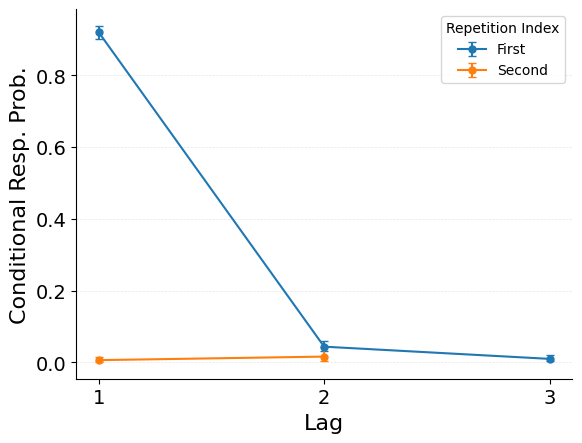

![](projects/thesis/figures/RepeatedRecallsGordonRanschburg2021_control_data_full_best_of_3_rep_crp.png)


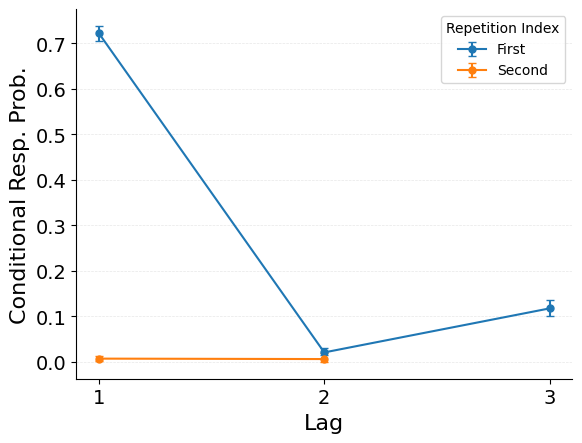

In [4]:
#|code-summary: single-dataset views


for analysis in single_analyses:
    figure_str = f"{data_tag}_mixed_data_{run_tag}_{analysis.__name__[5:]}.png"
    figure_path = os.path.join(product_dirs["figures"], figure_str)
    print(f"![]({figure_path})")

    # if redo_figures, check if figure already exists and don't redo
    # we want to display the figure here if it already exists
    if os.path.exists(figure_path) and not redo_figures:
        display(Image(filename=figure_path))
    else:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

        # Create a mask for data using np.isin for the selected list types
        trial_mask = generate_trial_mask(data, trial_query)

        axis = analysis(
            datasets=[data],
            trial_masks=[np.array(trial_mask)],
            color_cycle=color_cycle,
            labels=["First", "Second"],
            contrast_name="Repetition Index",
            axis=None,
            distances=None,
        )

        plt.savefig(figure_path, bbox_inches="tight", dpi=600)
        plt.show()

    figure_str = f"{data_tag}_control_data_{run_tag}_{analysis.__name__[5:]}.png"
    figure_path = os.path.join(product_dirs["figures"], figure_str)
    print(f"![]({figure_path})")

    # if redo_figures, check if figure already exists and don't redo
    # we want to display the figure here if it already exists
    if os.path.exists(figure_path) and not redo_figures:
        display(Image(filename=figure_path))
    else:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    ctrl_data = repetition.make_control_dataset(
        data,
        mixed_query=trial_query,
        control_query=control_trial_query,
        n_shuffles=10,
        seed=0,
            remove_repeats=filter_repeated_recalls,
        )
    control_trial_mask = jnp.ones((ctrl_data["recalls"].shape[0],), dtype=bool)

    axis = analysis(
        datasets=[ctrl_data],
        trial_masks=[np.array(control_trial_mask)],
        color_cycle=color_cycle,
        labels=["First", "Second"],
        contrast_name="Repetition Index",
        axis=None,
        distances=None,
    )

    plt.savefig(figure_path, bbox_inches="tight", dpi=600)
    plt.show()

![](projects/thesis/figures/RepeatedRecallsGordonRanschburg2021_mixedvscontrolA_data_full_best_of_3_spc.png)


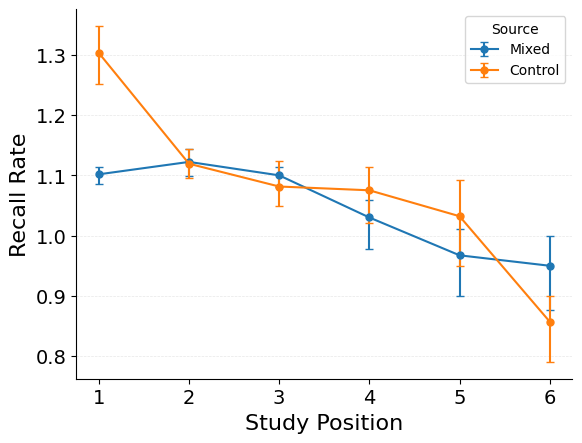

![](projects/thesis/figures/RepeatedRecallsGordonRanschburg2021_mixedvscontrolA_data_full_best_of_3_crp.png)


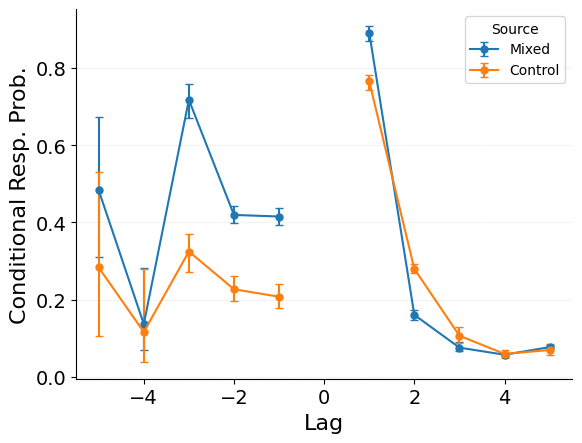

![](projects/thesis/figures/RepeatedRecallsGordonRanschburg2021_mixedvscontrolA_data_full_best_of_3_pnr.png)


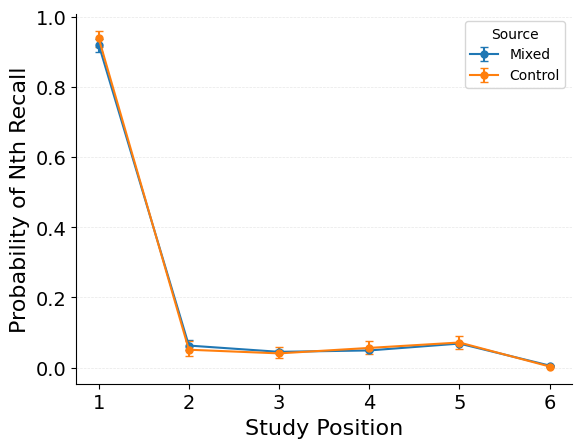

![](projects/thesis/figures/RepeatedRecallsGordonRanschburg2021_mixedvscontrolA_data_full_best_of_3_first_rep_crp.png)


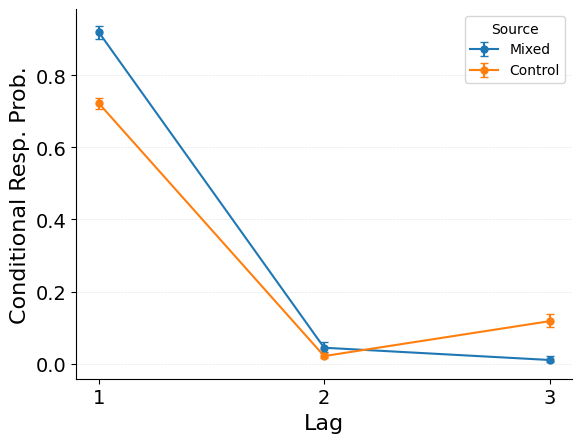

![](projects/thesis/figures/RepeatedRecallsGordonRanschburg2021_mixedvscontrolA_data_full_best_of_3_second_rep_crp.png)


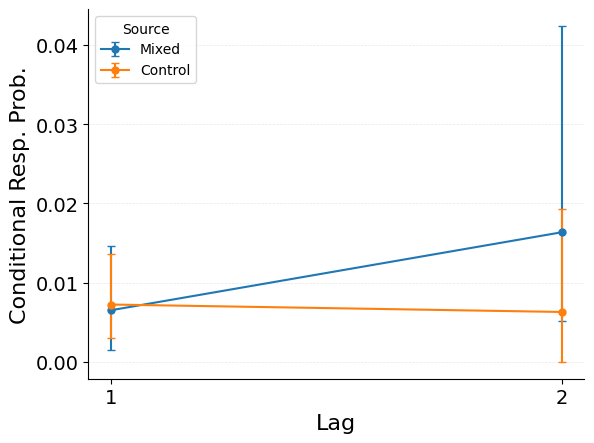

In [5]:
#| code-summary: mixed vs control views

for analysis in comparison_analyses:

    figure_str = f"{data_tag}_mixedvscontrolA_data_{run_tag}_{analysis.__name__[5:]}.png"
    figure_path = os.path.join(product_dirs["figures"], figure_str)
    print(f"![]({figure_path})")

    # if redo_figures, check if figure already exists and don't redo
    # we want to display the figure here if it already exists
    if os.path.exists(figure_path) and not redo_figures:
        display(Image(filename=figure_path))

    else:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

        ctrl_data =  repetition.make_control_dataset(
            data, mixed_query=trial_query,
            control_query=control_trial_query, n_shuffles=10, seed=0, remove_repeats=filter_repeated_recalls)
        
        mixed_trial_mask = generate_trial_mask(data, trial_query)
        control_trial_mask = jnp.ones((ctrl_data["recalls"].shape[0],), dtype=bool)

        axis = analysis(
            datasets=[data, ctrl_data],
            trial_masks=[np.array(mixed_trial_mask), np.array(control_trial_mask)],
            color_cycle=color_cycle,
            labels=["Mixed", "Control"],
            contrast_name="Source",
            axis=None,
            distances=None,
        )

        plt.savefig(figure_path, bbox_inches="tight", dpi=600)
        plt.show()

    # for non rep analyses, we'll also plot the mixed vs control
    # without our make_control_dataset remapping of study lists to trials
    # if "rep" in analysis.__name__:
    #     continue
    # figure_str = f"{data_tag}_mixedvscontrolB_data_{run_tag}_{analysis.__name__[5:]}.png"
    # figure_path = os.path.join(product_dirs["figures"], figure_str)
    # print(f"![]({figure_path})")

    # # if redo_figures, check if figure already exists and don't redo
    # # we want to display the figure here if it already exists
    # if os.path.exists(figure_path) and not redo_figures:
    #     display(Image(filename=figure_path))
    
    # else:

    #     color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    #     # Create a mask for data using np.isin for the selected list types
    #     mixed_trial_mask = generate_trial_mask(data, trial_query)
    #     control_trial_mask = generate_trial_mask(data, control_trial_query)

    #     axis = analysis(
    #         datasets=[data, data],
    #         trial_masks=[np.array(mixed_trial_mask), np.array(control_trial_mask)],
    #         color_cycle=color_cycle,
    #         labels=["Mixed", "Control"],
    #         contrast_name="Source",
    #         axis=None,
    #         distances=None,
    #     )

    #     plt.savefig(figure_path, bbox_inches="tight", dpi=600)
    #     plt.show()
